In [1]:
%%time

import hipscat
import os
from hipscat.pixel_math import HealpixPixel
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
import pyarrow.parquet as pq
import pandas as pd
from hipscat.inspection import plot_pixel_list, plot_pixels

catalog_dir = "/data3/epyc/data3/hipscat/catalogs/dp02"

catalog = hipscat.read_from_hipscat(catalog_dir)

CPU times: user 6.52 s, sys: 15.1 s, total: 21.6 s
Wall time: 16.6 s


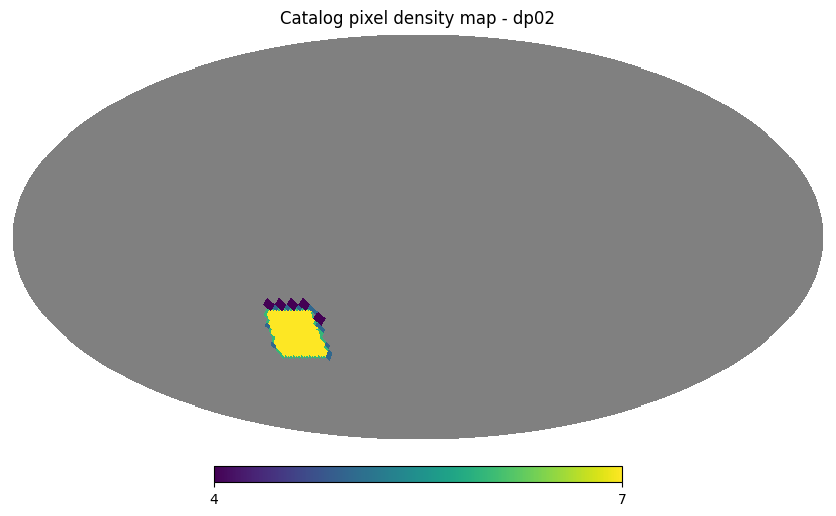

In [2]:
plot_pixels(catalog)

In [3]:
%%time

metadata_file = "/data3/epyc/data3/hipscat/catalogs/dp02/_metadata"

total_metadata = pq.read_metadata(metadata_file)
num_row_groups = total_metadata.num_row_groups
first_row_group = total_metadata.row_group(0)
norder_column = -1
npix_column = -1

for i in range(0, first_row_group.num_columns):
    column = first_row_group.column(i)
    if column.path_in_schema == "Norder":
        norder_column = i
    elif column.path_in_schema == "Npix":
        npix_column = i

if norder_column == -1 or npix_column == -1:
    raise ValueError("Metadata missing Norder or Npix column")

row_group_index = np.arange(0, num_row_groups)

pixel_tuples = [
    (
        total_metadata.row_group(index).column(norder_column).statistics.min,
        total_metadata.row_group(index).column(npix_column).statistics.min,
        total_metadata.row_group(index).num_rows,
        1,
    )
    for index in row_group_index
]

num_row_groups

CPU times: user 2.94 s, sys: 703 ms, total: 3.65 s
Wall time: 3.65 s


1671

In [5]:
pixel_frame = pd.DataFrame(pixel_tuples, columns=["Norder", "Npix", "num_rows", "num_groups"])
pixel_frame = pixel_frame.groupby(["Norder", "Npix"]).sum()
pixel_frame

num_rows  num_groups
Norder Npix                        
4      2173      173941           1
       2174      145394           1
       2246       49571           1
       2257      164953           1
       2258      165642           1
...                 ...         ...
7      144423    149947           1
       144424    177051           1
       144425    160470           1
       144426    179228           1
       144427    128534           1

[1671 rows x 2 columns]

In [6]:
info_frame = catalog.partition_info.as_dataframe()
for index, partition in info_frame.iterrows():
    file_name = result = hipscat.io.paths.pixel_catalog_file(
        catalog_dir, partition["Norder"], partition["Npix"]
    )
    info_frame.loc[index, "size_on_disk"] = os.path.getsize(file_name)

info_frame = info_frame.astype(int)
info_frame["gbs"] = info_frame["size_on_disk"] / (1024 * 1024 * 1024)

In [7]:
print(f'healpix orders: {info_frame["Norder"].unique()}')
print(f'num partitions: {len(info_frame["Npix"])}')
print("------")
print(f'min size_on_disk: {info_frame["gbs"].min():.2f}')
print(f'max size_on_disk: {info_frame["gbs"].max():.2f}')
print(f'size_on_disk ratio: {info_frame["gbs"].max()/info_frame["gbs"].min():.2f}')
print(f'total size_on_disk: {info_frame["gbs"].sum():.2f}')

healpix orders: [4 5 6 7]
num partitions: 1671
------
min size_on_disk: 0.00
max size_on_disk: 1.13
size_on_disk ratio: 1179.59
total size_on_disk: 1185.32


small-ish 	: 111 	(6.6 %)
sweet-spot 	: 1554 	(93.0 %)
big-ish 	: 6 	(0.4 %)
too-big 	: 0 	(0.0 %)


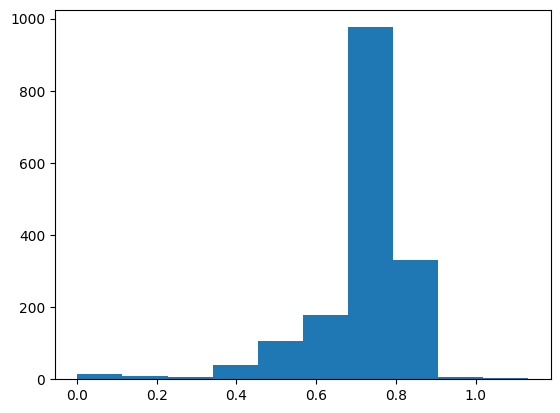

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(info_frame["gbs"])

bins = [0, 0.5, 1, 2, 100]
labels = ["small-ish", "sweet-spot", "big-ish", "too-big"]
hist = np.histogram(info_frame["gbs"], bins=bins)[0]
pcts = hist / len(info_frame)
for i in range(0, len(labels)):
    print(f"{labels[i]} \t: {hist[i]} \t({pcts[i]*100:.1f} %)")